In [8]:
import torch
import os
from model import BiSeNet
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
import numpy as np
from skimage.filters import gaussian
import argparse
from google.colab.patches import cv2_imshow

In [9]:
!git clone https://github.com/ahmeterenodaci/easygoogletranslate.git

Cloning into 'easygoogletranslate'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 19 (delta 7), reused 8 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 5.14 KiB | 5.14 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [10]:
cd easygoogletranslate/

/content/easygoogletranslate/easygoogletranslate


In [11]:
from easygoogletranslate import EasyGoogleTranslate
translator = EasyGoogleTranslate(source_language='fa',target_language='en',timeout=10)

In [12]:
color_code_dict = {'red': [0, 0, 255], 'blue':[255, 0, 0], 'yellow': [0, 255, 255], 'black': [0 ,0 ,0],
                   'silver': [192, 192, 192], 'white': [255, 255, 255], 'aqua': [255, 255 ,0],
                   'lime': [0, 255, 0], 'magenta': [255, 0, 255], 'gold': [0, 215, 225],
                   'maroon': [0, 0, 168], 'purple':[128, 0, 128],'green': [0, 128, 0], 'snow': [250, 250, 255],
                   'orange': [0, 165, 255],'pink': [203, 192, 255],'deep_pink':[147, 20, 255],
                   'indigo':[130, 0, 75],'brown':[42, 42, 165], 'chocolate': [30, 105, 210],
                   'tan': [140, 180, 210],'wheat':[179, 222, 245]}

In [13]:
def vis_parsing_maps(im, parsing_anno, stride, save_im=False, save_path='/content/sample_data'):
    # Colors for all 20 parts
    part_colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0],
                   [255, 0, 85], [255, 0, 170],
                   [0, 255, 0], [85, 255, 0], [170, 255, 0],
                   [0, 255, 85], [0, 255, 170],
                   [0, 0, 255], [85, 0, 255], [170, 0, 255],
                   [0, 85, 255], [0, 170, 255],
                   [255, 255, 0], [255, 255, 85], [255, 255, 170],
                   [255, 0, 255], [255, 85, 255], [255, 170, 255],
                   [0, 255, 255], [85, 255, 255], [170, 255, 255]]

    im = np.array(im)
    vis_im = im.copy().astype(np.uint8)
    vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
    vis_parsing_anno = cv2.resize(vis_parsing_anno, None, fx=stride, fy=stride, interpolation=cv2.INTER_NEAREST)
    vis_parsing_anno_color = np.zeros((vis_parsing_anno.shape[0], vis_parsing_anno.shape[1], 3)) + 255

    num_of_class = np.max(vis_parsing_anno)

    for pi in range(1, num_of_class + 1):
        index = np.where(vis_parsing_anno == pi)
        vis_parsing_anno_color[index[0], index[1], :] = part_colors[pi]

    vis_parsing_anno_color = vis_parsing_anno_color.astype(np.uint8)
    # print(vis_parsing_anno_color.shape, vis_im.shape)
    vis_im = cv2.addWeighted(cv2.cvtColor(vis_im, cv2.COLOR_RGB2BGR), 0.4, vis_parsing_anno_color, 0.6, 0)

    # Save result or not
    if save_im:
        cv2.imwrite(save_path[:-4] +'.png', vis_parsing_anno)
        cv2.imwrite(save_path, vis_im, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    return vis_parsing_anno
    # return vis_im


def evaluate(image_path='/content/6.jpg', cp='/content/drive/MyDrive/79999_iter.pth'):

    # if not os.path.exists(respth):
    #     os.makedirs(respth)

    n_classes = 19
    net = BiSeNet(n_classes=n_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device == 'cuda':
      net.cuda()
    net.load_state_dict(torch.load(cp,map_location=torch.device('cpu')))
    net.eval()

    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    with torch.no_grad():
        img = Image.open(image_path)
        image = img.resize((512, 512), Image.BILINEAR)
        img = to_tensor(image)
        img = torch.unsqueeze(img, 0)
        if device == 'cuda':
          img = img.cuda()
        out = net(img)[0]
        parsing = out.squeeze(0).cpu().numpy().argmax(0)
        # print(parsing)
        # print(np.unique(parsing))

        # vis_parsing_maps(image, parsing, stride=1, save_im=False, save_path=osp.join(respth, dspth))
        return parsing

In [14]:
def sharpen(img):
    img = img * 1.0
    gauss_out = gaussian(img, sigma=5, channel_axis= 1)

    alpha = 1.5
    img_out = (img - gauss_out) * alpha + img

    img_out = img_out / 255.0

    mask_1 = img_out < 0
    mask_2 = img_out > 1

    img_out = img_out * (1 - mask_1)
    img_out = img_out * (1 - mask_2) + mask_2
    img_out = np.clip(img_out, 0, 1)
    img_out = img_out * 255
    return np.array(img_out, dtype=np.uint8)


def hair(image, parsing, part=17, color=[230, 50, 20]):
    b, g, r = color      #[10, 50, 250]       # [10, 250, 10]
    tar_color = np.zeros_like(image)
    tar_color[:, :, 0] = b
    tar_color[:, :, 1] = g
    tar_color[:, :, 2] = r

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    tar_hsv = cv2.cvtColor(tar_color, cv2.COLOR_BGR2HSV)

    if part == 12 or part == 13:
        image_hsv[:, :, 0:2] = tar_hsv[:, :, 0:2]
    else:
        image_hsv[:, :, 0:1] = tar_hsv[:, :, 0:1]

    changed = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)

    if part == 17:
        changed = sharpen(changed)

    changed[parsing != part] = image[parsing != part]
    return changed

In [15]:
def changing_lips_and_hair_colors(Image_path = '/content/Test_image_for_face_2.jpg',
                                  Saved_weights = '/content/drive/MyDrive/79999_iter.pth',
                                  colors_hair = 'red',
                                  colors_upper_lips = 'red',
                                  colors_lower_lips = 'red'):
  table = {
      'hair': 17,
      'upper_lip': 12,
      'lower_lip': 13}
  image_path = Image_path
  cp = Saved_weights
  image = cv2.imread(image_path)
  image = cv2.resize(image,(1024, 1024))
  ori = image.copy()
  parsing = evaluate(image_path, cp)
  parsing = cv2.resize(parsing, image.shape[0:2], interpolation=cv2.INTER_NEAREST)
  parts = [table['hair'], table['upper_lip'], table['lower_lip']]

  colors = [color_code_dict[colors_hair], color_code_dict[colors_upper_lips], color_code_dict[colors_lower_lips]]
  for part, color in zip(parts, colors):
      image = hair(image, parsing, part, color)
  cv2_imshow(cv2.resize(ori, (512, 512)))
  cv2_imshow(cv2.resize(image, (512, 512)))
  cv2.waitKey(0)
  cv2.destroyAllWindows()


<ipython-input-13-bf0fbfe2f222>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(cp,map_location=torch.device('cpu')))


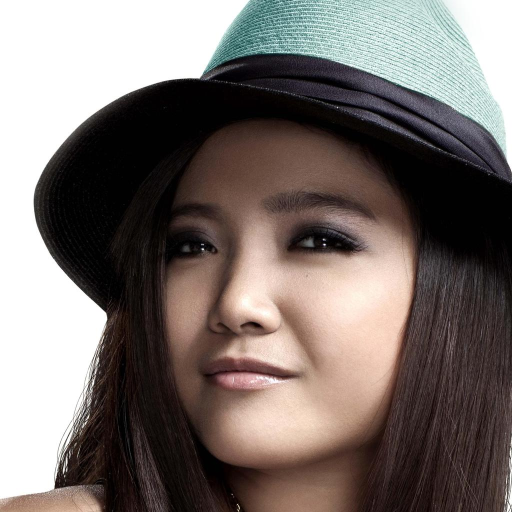

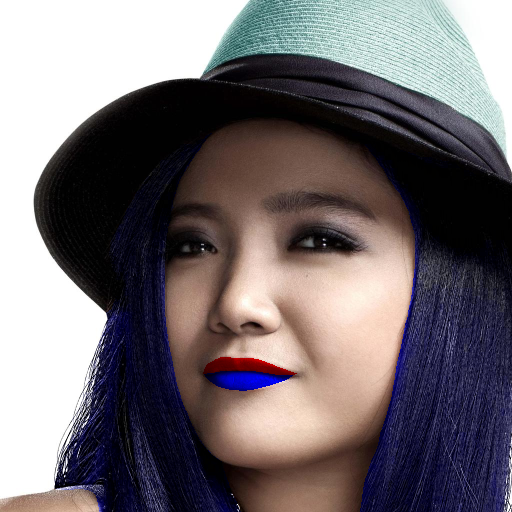

In [22]:
changing_lips_and_hair_colors(Image_path = '/content/6.jpg',
                                  Saved_weights = '/content/drive/MyDrive/79999_iter.pth',
                                  colors_hair =  translator.translate('آبی'),
                                  colors_upper_lips = translator.translate('قرمز'),
                                  colors_lower_lips = translator.translate('آبی'))